In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from time import time
import os

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('..')

import isolation
import sample_players
import run_match
import my_baseline_player as custom
import book as b

from multiprocessing.pool import ThreadPool as Pool
import pickle

Populating the interactive namespace from numpy and matplotlib


/Users/antelinvestigacionydesarrollo/anaconda3/envs/aind/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
with open('first_book.pkl', 'rb') as file:
    data = pickle.load(file)

In [3]:
data

{(Isolation(board=41198632737088974515941243613079551, ply_count=3, locs=(108, 83)),
  <Action.ESE: -15>): 0,
 (Isolation(board=40143957350286345584047904549496831, ply_count=3, locs=(106, 110)),
  <Action.WSW: -11>): 0,
 (Isolation(board=41523161126567869041879413484939263, ply_count=3, locs=(86, 53)),
  <Action.SSW: -25>): 0,
 (Isolation(board=41523161203939122082683630076618751, ply_count=3, locs=(31, 17)),
  <Action.ESE: -15>): 0,
 (Isolation(board=41523161203939122082683626855589879, ply_count=3, locs=(30, 32)),
  <Action.WSW: -11>): 0,
 (Isolation(board=41198484184284260270308255718172671, ply_count=3, locs=(108, 83)),
  <Action.ESE: -15>): 0,
 (Isolation(board=41520625901529739768237212624218111, ply_count=3, locs=(55, 101)),
  <Action.ENE: 11>): 0,
 (Isolation(board=41523161203939122082679234042521599, ply_count=3, locs=(42, 20)),
  <Action.NNW: 27>): 0,
 (Isolation(board=41523161203939122078180032462645247, ply_count=3, locs=(52, 16)),
  <Action.WNW: 15>): 0,
 (Isolation(board

## Let's first create some conversion functions, between the "book" format and the "nodes" format, used by MCTS

In [4]:
with open('base_book.pkl', 'rb') as file:
    data = pickle.load(file)

In [5]:
data

{(Isolation(board=41198484184284260270308255718172671, ply_count=3, locs=(108, 83)),
  <Action.ESE: -15>): [0, 0],
 (Isolation(board=40143957350286345584047904549496831, ply_count=3, locs=(106, 110)),
  <Action.WSW: -11>): [0, 0],
 (Isolation(board=41523161126567869041879413484939263, ply_count=3, locs=(86, 53)),
  <Action.SSW: -25>): [0, 0],
 (Isolation(board=41523161203937941491027730440906719, ply_count=3, locs=(45, 5)),
  <Action.WNW: 15>): [0, 0],
 (Isolation(board=41523161203939122082683626855589879, ply_count=3, locs=(30, 32)),
  <Action.WSW: -11>): [0, 0],
 (Isolation(board=41198632737088974515941243613079551, ply_count=3, locs=(108, 83)),
  <Action.ESE: -15>): [0, 0],
 (Isolation(board=41520625901529739768237212624218111, ply_count=3, locs=(55, 101)),
  <Action.ENE: 11>): [0, 0],
 (Isolation(board=41523161203939122082679232029255679, ply_count=3, locs=(42, 20)),
  <Action.NNW: 27>): [0, 0],
 (Isolation(board=41523161203939122078180032462645247, ply_count=3, locs=(52, 16)),
  <

In [6]:
len(data.keys())

374097

In [7]:
states = set(key[0] for key in data.keys())
len(states)

64898

In [8]:
s = states.pop()

In [9]:
s

Isolation(board=41523161202125733317232891443275775, ply_count=3, locs=(80, 79))

In [4]:
from collections import defaultdict

In [5]:
def q_fun():
    return defaultdict(float)

def n_fun():
    return defaultdict(int)

In [6]:
def book2q(book):
    Q = defaultdict(q_fun)
    N = defaultdict(n_fun)
    for s_a, q_n in book.items():
        state, action = s_a
        q, n = q_n
        Q[state][action] = 0 if n==0 else q / n
        N[state][action] = n
    return Q, N

In [7]:
def to_dict(q_book):
    book = q_book.copy()
    for key, value in book.items():
        book[key] = dict(value)
    return dict(book)

In [42]:
q = to_dict(q_book)

In [43]:
q

{Isolation(board=41502858977623435289258253189375999, ply_count=3, locs=(83, 104)): {<Action.SSW: -25>: 0,
  <Action.WSW: -11>: 0},
 Isolation(board=31138250574200520302340786809202687, ply_count=3, locs=(113, 74)): {<Action.SSE: -27>: 0,
  <Action.SSW: -25>: 0,
  <Action.ESE: -15>: 0,
  <Action.ENE: 11>: 0,
  <Action.NNE: 25>: 0,
  <Action.NNW: 27>: 0},
 Isolation(board=41523161202125733317232891443275775, ply_count=3, locs=(80, 79)): {<Action.SSE: -27>: 0,
  <Action.SSW: -25>: 0,
  <Action.WSW: -11>: 0,
  <Action.WNW: 15>: 0,
  <Action.NNE: 25>: 0,
  <Action.NNW: 27>: 0},
 Isolation(board=41520625902733940951554759958980607, ply_count=3, locs=(61, 101)): {<Action.SSE: -27>: 0,
  <Action.ESE: -15>: 0,
  <Action.ENE: 11>: 0},
 Isolation(board=41502561881675968621943571506784255, ply_count=3, locs=(73, 104)): {<Action.SSW: -25>: 0,
  <Action.WSW: -11>: 0},
 Isolation(board=41523161201521270443454373338015743, ply_count=2, locs=(81, 29)): {<Action.SSE: -27>: -1.0,
  <Action.SSW: -25>: -0

In [8]:
import os

def save_q(q_book, dirpath='..'):
    q = to_dict(q_book)
    with open(os.path.join(dirpath,'data.pickle'), 'wb') as file:
        pickle.dump(q, file)

In [45]:
save_q(q_book)

In [18]:
q_book, n_book = book2q(data)

In [19]:
q_book

defaultdict(<function __main__.q_fun()>,
            {Isolation(board=41522527378610673769085666001414143, ply_count=3, locs=(74, 73)): defaultdict(float,
                         {<Action.SSE: -27>: 0,
                          <Action.SSW: -25>: 0,
                          <Action.ESE: -15>: 0,
                          <Action.WSW: -11>: 0,
                          <Action.ENE: 11>: 0,
                          <Action.WNW: 15>: 0,
                          <Action.NNE: 25>: 0,
                          <Action.NNW: 27>: 0}),
             Isolation(board=41523161203939122082683627920812031, ply_count=3, locs=(32, 23)): defaultdict(float,
                         {<Action.ESE: -15>: 0,
                          <Action.ENE: 11>: 0,
                          <Action.NNE: 25>: 0}),
             Isolation(board=41502561872014006797992277399562239, ply_count=3, locs=(83, 104)): defaultdict(float,
                         {<Action.SSW: -25>: 0, <Action.WSW: -11>: 0}),
             Isola

In [22]:
q_book

defaultdict(<function __main__.q_fun()>,
            {Isolation(board=41522527378610673769085666001414143, ply_count=3, locs=(74, 73)): defaultdict(float,
                         {<Action.SSE: -27>: 0,
                          <Action.SSW: -25>: 0,
                          <Action.ESE: -15>: 0,
                          <Action.WSW: -11>: 0,
                          <Action.ENE: 11>: 0,
                          <Action.WNW: 15>: 0,
                          <Action.NNE: 25>: 0,
                          <Action.NNW: 27>: 0}),
             Isolation(board=41523161203939122082683627920812031, ply_count=3, locs=(32, 23)): defaultdict(float,
                         {<Action.ESE: -15>: 0,
                          <Action.ENE: 11>: 0,
                          <Action.NNE: 25>: 0}),
             Isolation(board=41502561872014006797992277399562239, ply_count=3, locs=(83, 104)): defaultdict(float,
                         {<Action.SSW: -25>: 0, <Action.WSW: -11>: 0}),
             Isola

In [9]:
with open('q_book.pkl', 'wb') as file:
    pickle.dump(q_book, file)
with open('../data.pickle', 'wb') as file:
    pickle.dump(q_book, file)
with open('n_book.pkl', 'wb') as file:
    pickle.dump(n_book, file)

NameError: name 'q_book' is not defined

In [10]:
from isolation.isolation import Isolation

test_state = Isolation(board=41523161203937941491058516766484479, ply_count=2, locs=(70, 42))

In [35]:
max(((k, v) for k, v in q_book[test_state].items()), key=lambda x: x[1])[0]

<Action.SSW: -25>

In [36]:
max(q_book[test_state].items(), key=lambda x: x[1])[0]

<Action.SSW: -25>

In [37]:
q_book[test_state]

defaultdict(float,
            {<Action.SSE: -27>: -0.3333333333333333,
             <Action.SSW: -25>: 1.0,
             <Action.ESE: -15>: 0,
             <Action.WSW: -11>: 0,
             <Action.ENE: 11>: 0,
             <Action.WNW: 15>: 0,
             <Action.NNE: 25>: 1.0,
             <Action.NNW: 27>: -1.0})

In [38]:
test_state in q_book.keys()

True

In [39]:
with open(os.path.join('..',"data.pickle"), "rb") as f:
    data = pickle.load(f)

In [40]:
data

defaultdict(<function __main__.q_fun()>,
            {Isolation(board=41522527378610673769085666001414143, ply_count=3, locs=(74, 73)): defaultdict(float,
                         {<Action.SSE: -27>: 0,
                          <Action.SSW: -25>: 0,
                          <Action.ESE: -15>: 0,
                          <Action.WSW: -11>: 0,
                          <Action.ENE: 11>: 0,
                          <Action.WNW: 15>: 0,
                          <Action.NNE: 25>: 0,
                          <Action.NNW: 27>: 0}),
             Isolation(board=41502858977623435289258253189375999, ply_count=3, locs=(83, 104)): defaultdict(float,
                         {<Action.SSW: -25>: 0, <Action.WSW: -11>: 0}),
             Isolation(board=31138250574200520302340786809202687, ply_count=3, locs=(113, 74)): defaultdict(float,
                         {<Action.SSE: -27>: 0,
                          <Action.SSW: -25>: 0,
                          <Action.ESE: -15>: 0,
                 

In [100]:
[state for state in data.keys() if state.ply_count==0]

[Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None))]

In [101]:
"""
book = {(state, action): [Q, N]}
nodes = {state0:[node_0_0, node_0_1, ...], state1:[node_1_0], ...}
node = {'state': state,
        'parent': parent,
        'from_action': from_action,
        'N': N,
        'Q': Q
        }
"""

"\nbook = {(state, action): [Q, N]}\nnodes = {state0:[node_0_0, node_0_1, ...], state1:[node_1_0], ...}\nnode = {'state': state,\n        'parent': parent,\n        'from_action': from_action,\n        'N': N,\n        'Q': Q\n        }\n"

## Let's try to fill some book entries with MCTS

In [11]:
def new_node(state, parent=None, from_action=None, N=0, Q=0, children=None):
    node = {'state': state,
            'parent': parent,
            'from_action': from_action,
            'N': N,
            'Q': Q
            }
    if children is None:
        node['children'] = list()
    else:
        node['children'] = children
    if parent is not None:
        parent['children'].append(node)
    return node

def ucb(node, c=1):
    if node['N'] == 0:
        if c != 0:
            return float('inf')
        else:
            return 0
    return (node['Q'] / node['N']) + c * math.sqrt((2 * math.log(node['N'])) / node['N'])


def best_node(node_list, c=1):
    return max(node_list, key=partial(ucb, c=c))


def best_child(node, c=1):
    return best_node(node['children'], c)


def expand(node):
    a = random.choice(unexplored_actions(node))
    child = new_node(state=node['state'].result(a),
                                  parent=node,
                                  from_action=a)
    node['children'].append(child)
    return child


def unexplored_actions(node):
    return list(set(node['state'].actions()) -
                set(child['from_action'] for child in node['children']))


def is_fully_expanded(node):
    return len(unexplored_actions(node)) == 0


def backup_negamax(node, reward):
    temp_node = node
    temp_node['N'] += 1
    temp_node['Q'] += reward
    while temp_node['parent'] is not None:
        temp_node = temp_node['parent']
        temp_node['N'] += 1
        temp_node['Q'] += reward


def get_root_node(state, nodes=None):
    """
    nodes = {
        state1: [node1_1, node1_2],
        state2: [node2_1],
        state3: [node3_1, node3_2, node3_3]
    }
    """
    if nodes is None:
        nodes = dict()
    if state not in nodes.keys():
        node = new_node(state)
        nodes[state] = [node]
        return node, nodes
    else:
        return best_node(nodes[state]), nodes

### The only thing to change is the default policy

In [12]:
import isolation
import sample_players
import run_match
import my_book_player as custom
import book as b

from multiprocessing.pool import ThreadPool as Pool

In [13]:
# Constant parameteres
time_limit = 150
depth = 4
full_search_depth = 2
matches_per_opening = 3

# Create the agents that will play
agent_names = ('CustomPlayer1', 'CustomPlayer2')
agent1 = isolation.Agent(custom.CustomPlayer, agent_names[0])
agent2 = isolation.Agent(custom.CustomPlayer, agent_names[1])
agents = (agent1, agent2)

#  (agents, state, time_limit, match_id)

In [14]:
from functools import partial

In [15]:
def tree_policy(node, nodes=None):
    if nodes is None:
        nodes = dict()
    temp_node = node
    tree_history = list()
    while not temp_node['state'].terminal_test():
        if is_fully_expanded(temp_node):
            temp_node = best_child(temp_node)
            tree_history.append(temp_node['from_action'])
        else:
            child = expand(temp_node)
            if child['state'] not in nodes.keys():
                nodes[child['state']] = [child]
            else:
                nodes[child['state']].append(child)
            tree_history.append(child['from_action'])
            return child, tree_history
    return temp_node, tree_history

In [16]:
def uct_search(root_n, book, depth, nodes=None):
    """
    nodes contains a dictionary of state:node with the nodes that have
    already been visited.
    """
    edge_node, tree_history = tree_policy(root_n, nodes)
    reward, game_history, winner_id = default_policy(edge_node['state'])
    # Add data to the book
    game_history = tree_history + game_history
    b.process_game_history(root_n['state'],
                         game_history,
                         book,
                         winner_id,
                         active_player=0,
                         depth=depth)
    backup_negamax(edge_node, reward)
    return best_child(root_n, 0)['from_action'], nodes  # Greedy, so c = 0

In [17]:
def default_policy(state):
    player_id = state.player()
    winner, game_history, match_id = isolation.play((agents, state, time_limit, 0))
    winner_id = agent_names.index(winner.name)
    game_value = 2 * (player_id == winner_id) - 1
    return game_value, game_history, winner_id

In [15]:
default_policy(isolation.isolation.Isolation())

(-1,
 [44,
  27,
  <Action.NNE: 25>,
  <Action.NNE: 25>,
  <Action.NNE: 25>,
  <Action.WSW: -11>,
  <Action.ESE: -15>,
  <Action.NNW: 27>,
  <Action.SSW: -25>,
  <Action.SSW: -25>,
  <Action.SSW: -25>,
  <Action.SSW: -25>,
  <Action.ENE: 11>,
  <Action.WNW: 15>,
  <Action.NNE: 25>,
  <Action.NNW: 27>,
  <Action.WNW: 15>,
  <Action.NNE: 25>,
  <Action.SSE: -27>,
  <Action.ENE: 11>,
  <Action.WSW: -11>,
  <Action.SSW: -25>,
  <Action.SSW: -25>,
  <Action.ESE: -15>,
  <Action.WNW: 15>,
  <Action.SSW: -25>,
  <Action.NNE: 25>,
  <Action.WNW: 15>,
  <Action.SSE: -27>,
  <Action.WSW: -11>,
  <Action.NNE: 25>,
  <Action.ESE: -15>,
  <Action.WNW: 15>,
  <Action.NNE: 25>,
  <Action.NNE: 25>,
  <Action.WSW: -11>,
  <Action.WSW: -11>,
  <Action.NNE: 25>,
  <Action.WSW: -11>,
  <Action.WNW: 15>,
  <Action.NNE: 25>,
  <Action.NNW: 27>,
  <Action.ESE: -15>,
  <Action.ENE: 11>,
  <Action.WSW: -11>,
  <Action.ESE: -15>,
  <Action.SSW: -25>,
  <Action.WSW: -11>,
  <Action.ENE: 11>],
 1)

In [18]:
# Load the last nodes and book, if wanted
with open('nodes.pkl', 'rb') as file:
    nodes = pickle.load(file)
with open('tree_book.pkl', 'rb') as file:
    book = pickle.load(file)

In [19]:
# Initialize book
depth = 4
root_s = isolation.isolation.Isolation()
book = b.get_empty_book(root_s, depth=depth)

# Get root node
root_n, nodes = get_root_node(root_s, nodes)
root_n['parent'] = None  # Set this one as the new root
root_n['from_action'] = None  # Just for completeness, not used by now

In [20]:
root_n

{'N': 3242,
 'Q': -22,
 'children': [{'N': 28,
   'Q': -4,
   'children': [{'N': 1,
     'Q': 1,
     'children': [],
     'from_action': 98,
     'parent': {...},
     'state': Isolation(board=41522844291270175559401779467642879, ply_count=2, locs=(74, 98))},
    {'N': 1,
     'Q': 1,
     'children': [],
     'from_action': 98,
     'parent': {...},
     'state': Isolation(board=41522844291270175559401779467642879, ply_count=2, locs=(74, 98))},
    {'N': 1,
     'Q': -1,
     'children': [],
     'from_action': 72,
     'parent': {...},
     'state': Isolation(board=41523161203915510250269283998230527, ply_count=2, locs=(74, 72))},
    {'N': 1,
     'Q': -1,
     'children': [],
     'from_action': 72,
     'parent': {...},
     'state': Isolation(board=41523161203915510250269283998230527, ply_count=2, locs=(74, 72))},
    {'N': 1,
     'Q': -1,
     'children': [],
     'from_action': 22,
     'parent': {...},
     'state': Isolation(board=41523161203920232616752153639249919, ply_co

In [21]:
from time import time
batch_size = 10

while True:
    t0 = time()
    for i in range(batch_size):
        action, nodes = uct_search(root_n, book, depth, nodes)
        print('iter {}: action {}, nodes {}'.format(i, action, len(nodes)))
    # print([str(state) for state in nodes.keys()])
    print('Saving nodes...')
    with open('nodes.pkl', 'wb') as file:
        pickle.dump(nodes, file)
    print('Saving book...')
    with open('tree_book.pkl', 'wb') as file:
        pickle.dump(book, file)
    batch_time = time() - t0
    print('Elapsed time: {} ({} seconds per iter)'.format(batch_time, batch_time/ batch_size))

iter 0: action 94, nodes 5751
iter 1: action 94, nodes 5752
iter 2: action 94, nodes 5753
iter 3: action 94, nodes 5754
iter 4: action 94, nodes 5755
iter 5: action 94, nodes 5756
iter 6: action 5, nodes 5757
iter 7: action 5, nodes 5758
iter 8: action 5, nodes 5759
iter 9: action 5, nodes 5760
Saving nodes...
Saving book...
Elapsed time: 133.31536984443665 (13.331536984443664 seconds per iter)
iter 0: action 114, nodes 5761
iter 1: action 5, nodes 5762
iter 2: action 5, nodes 5763
iter 3: action 5, nodes 5763
iter 4: action 5, nodes 5764
iter 5: action 5, nodes 5764
iter 6: action 5, nodes 5765
iter 7: action 5, nodes 5766
iter 8: action 5, nodes 5766
iter 9: action 5, nodes 5767
Saving nodes...
Saving book...
Elapsed time: 124.37452387809753 (12.437452387809753 seconds per iter)
iter 0: action 5, nodes 5768
iter 1: action 5, nodes 5769
iter 2: action 5, nodes 5770
iter 3: action 5, nodes 5771
iter 4: action 5, nodes 5772
iter 5: action 5, nodes 5773
iter 6: action 5, nodes 5774
iter 

Elapsed time: 121.93576288223267 (12.193576288223266 seconds per iter)
iter 0: action 97, nodes 5897
iter 1: action 97, nodes 5898
iter 2: action 97, nodes 5899
iter 3: action 97, nodes 5900
iter 4: action 97, nodes 5901
iter 5: action 97, nodes 5902
iter 6: action 97, nodes 5903
iter 7: action 97, nodes 5904
iter 8: action 97, nodes 5905
iter 9: action 97, nodes 5906
Saving nodes...
Saving book...
Elapsed time: 116.29766607284546 (11.629766607284546 seconds per iter)
iter 0: action 97, nodes 5907
iter 1: action 97, nodes 5908
iter 2: action 97, nodes 5909
iter 3: action 97, nodes 5910
iter 4: action 97, nodes 5911
iter 5: action 97, nodes 5912
iter 6: action 97, nodes 5913
iter 7: action 97, nodes 5914
iter 8: action 97, nodes 5915
iter 9: action 97, nodes 5916
Saving nodes...
Saving book...
Elapsed time: 124.13254809379578 (12.413254809379577 seconds per iter)
iter 0: action 97, nodes 5917
iter 1: action 97, nodes 5918
iter 2: action 97, nodes 5919
iter 3: action 97, nodes 5920
iter 

iter 3: action 97, nodes 6064
iter 4: action 97, nodes 6064
iter 5: action 97, nodes 6064
iter 6: action 97, nodes 6064
iter 7: action 97, nodes 6065
iter 8: action 97, nodes 6066
iter 9: action 97, nodes 6067
Saving nodes...
Saving book...
Elapsed time: 126.29941487312317 (12.629941487312317 seconds per iter)
iter 0: action 97, nodes 6067
iter 1: action 97, nodes 6068
iter 2: action 97, nodes 6069
iter 3: action 97, nodes 6069
iter 4: action 97, nodes 6070
iter 5: action 97, nodes 6071
iter 6: action 97, nodes 6072
iter 7: action 97, nodes 6073
iter 8: action 97, nodes 6074
iter 9: action 97, nodes 6075
Saving nodes...
Saving book...
Elapsed time: 122.96902394294739 (12.296902394294738 seconds per iter)
iter 0: action 97, nodes 6076
iter 1: action 97, nodes 6077
iter 2: action 97, nodes 6078
iter 3: action 97, nodes 6079
iter 4: action 97, nodes 6079
iter 5: action 97, nodes 6080
iter 6: action 97, nodes 6081
iter 7: action 97, nodes 6082
iter 8: action 97, nodes 6083
iter 9: action 9

iter 9: action 97, nodes 6215
Saving nodes...
Saving book...
Elapsed time: 130.1468710899353 (13.014687108993531 seconds per iter)
iter 0: action 97, nodes 6216
iter 1: action 97, nodes 6217
iter 2: action 97, nodes 6218
iter 3: action 97, nodes 6219
iter 4: action 97, nodes 6220
iter 5: action 97, nodes 6220
iter 6: action 97, nodes 6220
iter 7: action 97, nodes 6221
iter 8: action 97, nodes 6222
iter 9: action 97, nodes 6223
Saving nodes...
Saving book...
Elapsed time: 127.79317998886108 (12.779317998886109 seconds per iter)
iter 0: action 97, nodes 6224


Process Process-39797:
Traceback (most recent call last):
  File "/Users/antelinvestigacionydesarrollo/anaconda3/envs/aind/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/Users/antelinvestigacionydesarrollo/anaconda3/envs/aind/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


KeyboardInterrupt: 

  File "../isolation/__init__.py", line 214, in _request_action
    agent.get_action(game_state)
  File "../isolation/__init__.py", line 191, in _func
    return func(*args, **kwargs)
  File "../my_book_player.py", line 124, in get_action
    self.queue.put(self.alpha_beta_search(state, depth))
  File "../isolation/__init__.py", line 191, in _func
    return func(*args, **kwargs)
  File "../my_book_player.py", line 47, in alpha_beta_search
    v = self.min_value(state.result(a), alpha, beta, depth - 1)
  File "../isolation/__init__.py", line 191, in _func
    return func(*args, **kwargs)
  File "../my_book_player.py", line 67, in min_value
    v = min(v, self.max_value(state.result(a), alpha, beta, depth - 1))
  File "../isolation/__init__.py", line 191, in _func
    return func(*args, **kwargs)
  File "../my_book_player.py", line 86, in max_value
    v = max(v, self.min_value(state.result(a), alpha, beta, depth - 1))
  File "../isolation/__init__.py", line 191, in _func
    return fun

Populating the interactive namespace from numpy and matplotlib


/Users/antelinvestigacionydesarrollo/anaconda3/envs/aind/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


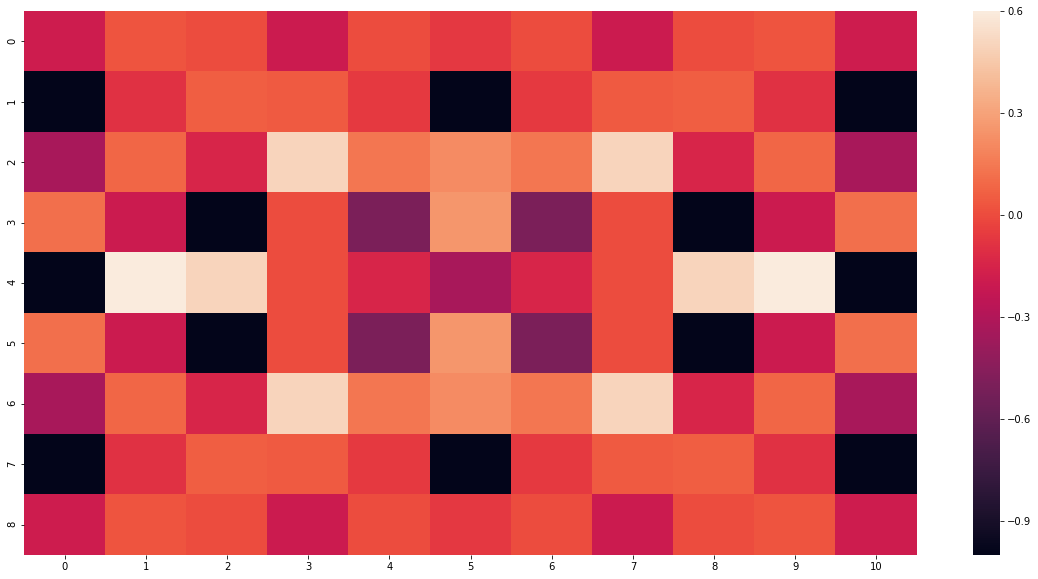

In [22]:
# Show the best first moves...
%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

import seaborn as sns

first = {item:value[0]/value[1] for item, value in book.items() if item[0].ply_count==0 and value[1] != 0}
pos_value = {key[1]:value for key,value in first.items()}
filled_vals = dict(zip(range(115),[0]*115))
filled_vals.update(pos_value)
W = 11
x = list(filled_vals.values())
rows = [x[i*(W+2):(i+1)*(W+2)] 
           for i in range(len(x) // (W+2) + (len(x) % (W+2) != 0))]
for i in range(len(rows)-1):
    rows[i] =rows[i][:-2]
rows = np.array(rows)
sns.heatmap(rows)

## Combine 2 books...

In [23]:
def combine_books(b1, b2):
    comb = dict()
    keys = set(b1.keys()) | set(b2.keys())
    for k in keys:
        comb[k] = [0, 0]
        if k in b1.keys():
            comb[k][0] += b1[k][0]
            comb[k][1] += b1[k][1]
        if k in b2.keys():
            comb[k][0] += b2[k][0]
            comb[k][1] += b2[k][1]
    return comb

In [24]:
b1 = {'a':[3, 10], 'c':[1,57]}
b2 = {'a':[5,11], 'b':[-34, 1892]}

In [25]:
combine_books(b1, b2)

{'a': [8, 21], 'b': [-34, 1892], 'c': [1, 57]}

In [26]:
book

{(Isolation(board=41198632737088974515941243613079551, ply_count=3, locs=(108, 83)),
  <Action.ESE: -15>): [0, 0],
 (Isolation(board=40143957350286345584047904549496831, ply_count=3, locs=(106, 110)),
  <Action.WSW: -11>): [0, 0],
 (Isolation(board=41523161203937941491027730440906719, ply_count=3, locs=(45, 5)),
  <Action.WNW: 15>): [0, 0],
 (Isolation(board=41523161203939122082683626855589879, ply_count=3, locs=(30, 32)),
  <Action.WSW: -11>): [0, 0],
 (Isolation(board=41198484184284260270308255718172671, ply_count=3, locs=(108, 83)),
  <Action.ESE: -15>): [0, 0],
 (Isolation(board=41520625901529739768237212624218111, ply_count=3, locs=(55, 101)),
  <Action.ENE: 11>): [0, 0],
 (Isolation(board=41523161203939122082679232029255679, ply_count=3, locs=(42, 20)),
  <Action.NNW: 27>): [0, 0],
 (Isolation(board=41523161203939122078180032462645247, ply_count=3, locs=(52, 16)),
  <Action.WNW: 15>): [0, 0],
 (Isolation(board=41523161203934397410357753298282495, ply_count=3, locs=(61, 26)),
  <A

In [27]:
print(isolation.DebugState.from_state(root_s.result(52)))


+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   | 1 |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +



In [28]:
visited = [key for key, v in book.items() if v[1]>0]

In [29]:
len(visited)

3743

In [30]:
max_key = max(book.keys(), key=lambda x: book[x][1])

In [31]:
max_key

(Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
 95)

In [32]:
book[max_key]

[-9, 159]

In [33]:
with open('base_book.pkl', 'rb') as file:
    base_book = pickle.load(file)

In [34]:
full_book = combine_books(base_book, book)

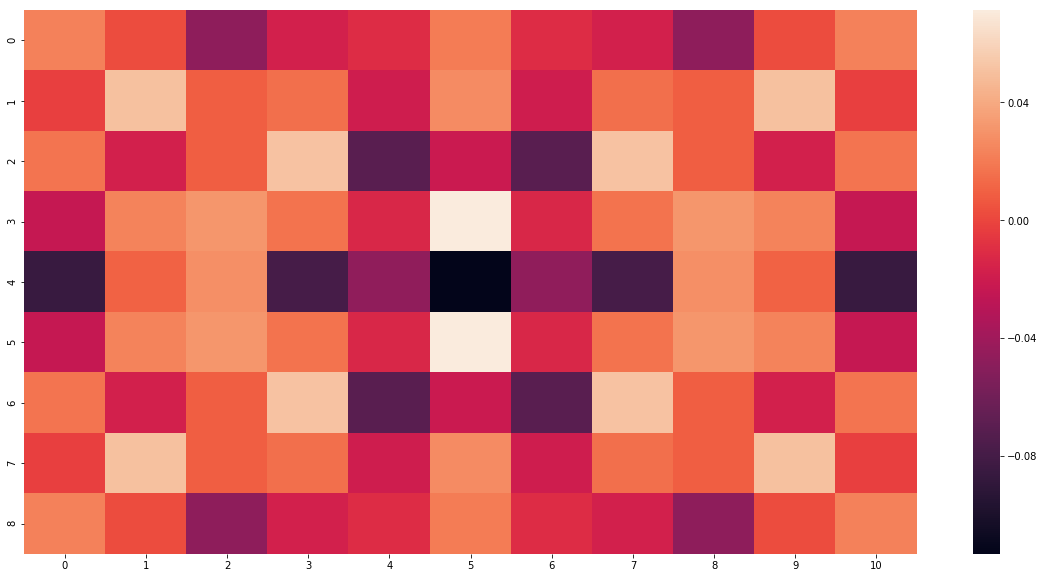

In [35]:
first = {item:value[0]/value[1] for item, value in full_book.items() if item[0].ply_count==0}
pos_value = {key[1]:value for key,value in first.items()}
filled_vals = dict(zip(range(115),[0]*115))
filled_vals.update(pos_value)
W = 11
x = list(filled_vals.values())
rows = [x[i*(W+2):(i+1)*(W+2)] 
           for i in range(len(x) // (W+2) + (len(x) % (W+2) != 0))]
for i in range(len(rows)-1):
    rows[i] =rows[i][:-2]
rows = np.array(rows)
sns.heatmap(rows)

In [36]:
with open('full_book.pkl', 'wb') as file:
    pickle.dump(full_book, file)

In [40]:
first_moves = {key:value for key, value in full_book.items()
               if key[0][1]==0}

In [41]:
first_moves

{(Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  0): [28, 1238],
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  1): [3, 1223],
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  2): [-56, 1188],
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  3): [-20, 1192],
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  4): [-13, 1199],
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  5): [26, 1278],
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  6): [-13, 1199],
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  7): [-20, 1192],
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  8): [-56, 1188],
 (Isolation(board=41523161203939122082683

In [44]:
max_first = max(value[0]/value[1] for value in first_moves.values())
max_first

0.07131011608623548

In [45]:
best_moves = [key[1] for key, value in first_moves.items() if value[0]/value[1] == max_first]

In [46]:
best_moves

[70, 44]

In [47]:
print(isolation.DebugState.from_state(root_s.result(70).result(44)))


+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   | 1 |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   | 2 |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +



In [60]:
second_70 = {key:value for key, value in full_book.items()
               if key[0][2][0]==70 and key[0][1] == 1}

In [61]:
second_70

{(Isolation(board=41523161203937941491062914812995583, ply_count=1, locs=(70, None)),
  0): [0, 12],
 (Isolation(board=41523161203937941491062914812995583, ply_count=1, locs=(70, None)),
  1): [2, 12],
 (Isolation(board=41523161203937941491062914812995583, ply_count=1, locs=(70, None)),
  2): [-4, 14],
 (Isolation(board=41523161203937941491062914812995583, ply_count=1, locs=(70, None)),
  3): [10, 12],
 (Isolation(board=41523161203937941491062914812995583, ply_count=1, locs=(70, None)),
  4): [-12, 12],
 (Isolation(board=41523161203937941491062914812995583, ply_count=1, locs=(70, None)),
  5): [4, 12],
 (Isolation(board=41523161203937941491062914812995583, ply_count=1, locs=(70, None)),
  6): [-12, 12],
 (Isolation(board=41523161203937941491062914812995583, ply_count=1, locs=(70, None)),
  7): [10, 12],
 (Isolation(board=41523161203937941491062914812995583, ply_count=1, locs=(70, None)),
  8): [-4, 14],
 (Isolation(board=41523161203937941491062914812995583, ply_count=1, locs=(70, None)

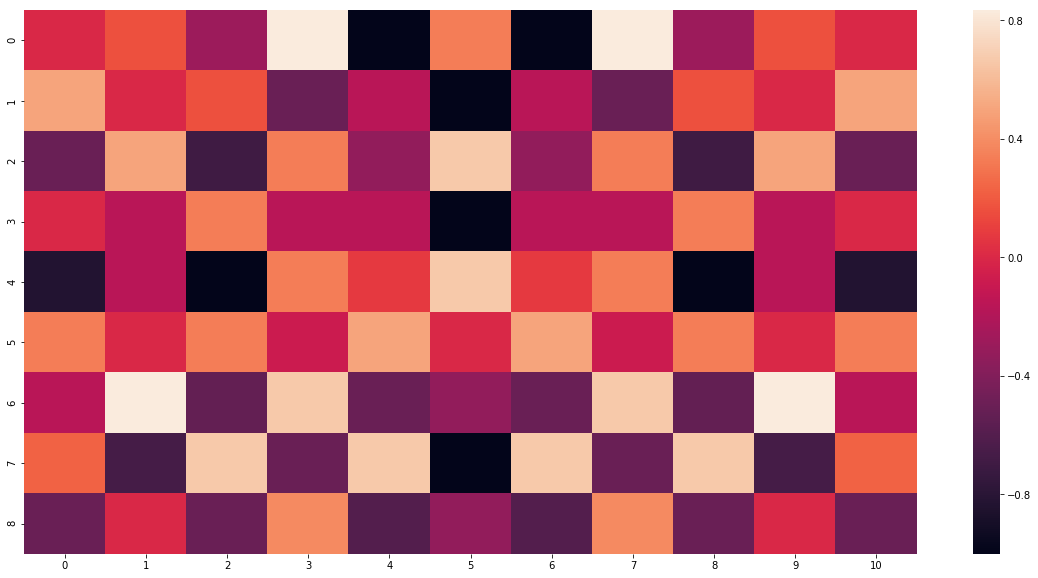

In [64]:
first = {item:value[0]/value[1] for item, value in second_70.items() if value[1] != 0}
pos_value = {key[1]:value for key,value in first.items()}
filled_vals = dict(zip(range(115),[0]*115))
filled_vals.update(pos_value)
W = 11
x = list(filled_vals.values())
rows = [x[i*(W+2):(i+1)*(W+2)] 
           for i in range(len(x) // (W+2) + (len(x) % (W+2) != 0))]
for i in range(len(rows)-1):
    rows[i] =rows[i][:-2]
rows = np.array(rows)
sns.heatmap(rows)

In [65]:
max_second = max(value[0]/value[1] for value in second_70.values())
best_moves = [key[1] for key, value in second_70.items() if value[0]/value[1] == max_second]
best_moves

[7, 79, 87, 3]

In [66]:
print(isolation.DebugState.from_state(root_s.result(7).result(3)))


+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   | 1 |   |   |   | 2 |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +



In [67]:
print(isolation.DebugState.from_state(root_s.result(79).result(87)))


+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   | 2 |   |   |   |   |   |   |   | 1 |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +

